In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sp
%load_ext autoreload
%autoreload 2

# data path, constants, etc..
import sys
datapath = '/Users/nhamilto/Documents/ATom/coderepo/ATom/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import matplotlib.cm as cm

# Acoustic tomography functions
import atom_functions as ATF
import atom_classes as ATC

In [2]:
dset = ATC.dataset('/Users/nhamilto/Documents/ATom/data/20181005_Data_collection/')
dset.load_data_sample(0)

In [3]:
ATom_signals, travel_times, travel_time_inds = dset.extract_travel_times(upsamplefactor=5)

In [4]:
dset.load_aux(0)
dset.aux_data.mean()

vx      6.566282
vy      1.148513
vz      0.015764
c     334.795841
T      17.620516
H      34.283393
dtype: float64

## prototyping meanfield calcs from tt

In [5]:
# gamma = Cp/Ct ratio of specific heats of air
gamma = 1.4
# Gas constant for air
Ra = 287.058
gR = gamma*Ra

In [6]:
path_velocity = pd.DataFrame()
for col in travel_times.columns:
    path_velocity[col] =dset.path_lengths.flatten()/(travel_times[col]/1000)

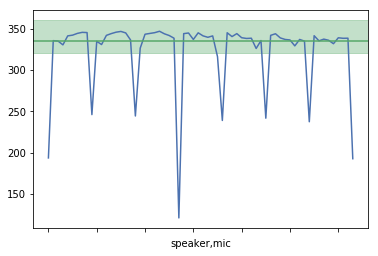

In [7]:
path_velocity['frame 0'].plot()
plt.axhline(dset.aux_data['c'].mean(), color='C1')
# plt.axhspan(0.9*dset.aux_data['c'].mean(),1.1*dset.aux_data['c'].mean(), color='C1', alpha=0.35)
plt.axhspan(320,360, color='C1', alpha=0.35)

(23242.68347156849, 23339.8272240315, 230752.8784671025, 230845.33691729742)

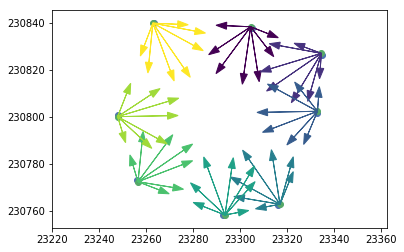

In [19]:
# info for drawing arrows from speakers to mics
arx = dset.speaker_xy_m[:,0]
ary = dset.speaker_xy_m[:,1]
ardx = 0.25*dset.distx
ardy = 0.25*dset.disty


fig, ax = plt.subplots()

cmp = cm.viridis
colors = np.linspace(0,1,8)

for spknum in range(8):
    for micnum in range(8):
        if spknum == micnum:
            continue
        plt.arrow(arx[spknum], ary[spknum], ardx[micnum,spknum], ardy[micnum,spknum],
                  head_width=3, color=cmp(colors[spknum]))

ax.scatter(dset.mic_xy_m[:,0], dset.mic_xy_m[:,1])
ax.scatter(dset.speaker_xy_m[:,0], dset.speaker_xy_m[:,1])

plt.axis('equal')


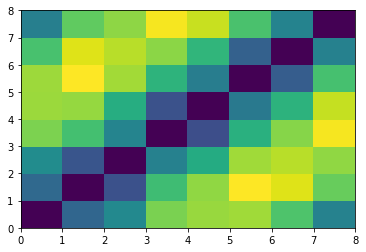

In [9]:
plt.pcolor(dset.path_lengths)

In [22]:
np.degrees(phi[0,:])

array([149.7315875 , 339.61054219, 308.00011369, 278.96924497,
       261.7669202 , 233.4783082 , 213.50868308, 177.42910696])

In [20]:
# angle of travel path wrt Cartesian axes aligned with the cardinal directions
dx = dset.distx
dy = dset.disty
# angle of travel path (add pi )
phi = np.arctan2(dy,dx) + np.pi
# np.degrees(phi).round(1)

In [23]:
# angle of travel path wrt Cartesian axes aligned with the cardinal directions
dx = dset.distx
dy = dset.disty
# angle of travel path (add pi )
phi = np.arctan2(dy,dx) + np.pi

# set up least-squares problem
G = np.ones((56,3))
# get rid of diagonal elements (speaker_i to mic_i)
phinodiag = phi[~np.eye(phi.shape[0],dtype=bool)]
G[:,1] = -np.cos(phinodiag)
G[:,2] = -np.sin(phinodiag)
Ginv = np.linalg.pinv(G)

# pick a frame to look at
frameID=0
pv = path_velocity['frame 0']
pv[::9] = np.NaN
# D = 1/C
D = 1/pv.dropna()
# aver = average values of [1/c0, vx/c0**2, vy/c0**2]
aver = np.matmul(Ginv,D)
# Di is the least-squares estiamte of D
Di = np.matmul(G,aver)
# Residual and rmse
residual = Di-D
rmse = np.linalg.norm(residual)/(56-3)

# estimated speed of sound during frame
c0est = 1/aver[0]

# error of each term in Aver
std_aver = np.sqrt(rmse*np.diag(np.matmul(Ginv,Ginv.T)))

err_c0 = std_aver[0]*c0est**2
err_c2 = 2*c0est*err_c0

# estimate of mean temperature from data
T0est = c0est**2/gR
# error estiamte of T
err_T = err_c2/gR

# mean field estimates of vx and vy
vx0est = aver[1]*c0est**2
vy0est = aver[2]*c0est**2

# error of mean field estimates of vx and vy
err_vx = c0est**2*std_aver[1]
err_vy = c0est**2*std_aver[2]

print('vx0 = {}'.format(vx0est))
print('vy0 = {}'.format(vy0est))
print('c0 = {}'.format(c0est))
print('T0 = {}'.format(T0est-273))

print(dset.aux_data.mean())

# compare velocity vector magnitudes
vmag0 = np.sqrt(vx0est**2 + vy0est**2)
vmagaux = np.sqrt(dset.aux_data.mean()['vx']**2 + dset.aux_data.mean()['vy']**2)

print('vmagAT = {}'.format(vmag0))
print('vmagAUX = {}'.format(vmagaux))

vx0 = -5.308248661423813
vy0 = 2.912643778658591
c0 = 338.7726016921907
T0 = 12.57413399107918
vx      6.566282
vy      1.148513
vz      0.015764
c     334.795841
T      17.620516
H      34.283393
dtype: float64
vmagAT = 6.054832585040341
vmagAUX = 6.665968488423796


In [25]:
# angle of travel path wrt Cartesian axes aligned with the cardinal directions
dx = dset.distx
dy = dset.disty
# angle of travel path (add pi )
phi = np.arctan2(dy,dx) + np.pi

# set up least-squares problem
G = np.ones((56,3))
# get rid of diagonal elements (speaker_i to mic_i)
phinodiag = phi[~np.eye(phi.shape[0],dtype=bool)]
G[:,1] = -np.cos(phinodiag)
G[:,2] = -np.sin(phinodiag)
Ginv = np.linalg.pinv(G)

# pick a frame to look at
c0est = np.zeros(120)
T0est = np.zeros(120)
vx0est = np.zeros(120)
vy0est = np.zeros(120)

for frameID in range(120):
    pv = path_velocity['frame {}'.format(frameID)]
    pv[::9] = np.NaN
    # D = 1/C
    D = 1/pv.dropna()
    # aver = average values of [1/c0, vx/c0**2, vy/c0**2]
    aver = np.matmul(Ginv,D)
    # Di is the least-squares estiamte of D
    Di = np.matmul(G,aver)
    # Residual and rmse
    residual = Di-D
    rmse = np.linalg.norm(residual)/(56-3)

    # estimated speed of sound during frame
    c0est[frameID]  = 1/aver[0]

    # error of each term in Aver
    std_aver = np.sqrt(rmse*np.diag(np.matmul(Ginv,Ginv.T)))

    err_c0 = std_aver[0]*c0est**2
    err_c2 = 2*c0est*err_c0

    # estimate of mean temperature from data
    T0est[frameID]  = c0est[frameID]**2/gR
    # error estiamte of T
    err_T = err_c2/gR

    # mean field estimates of vx and vy
    vx0est[frameID] = aver[1]*c0est[frameID]**2
    vy0est[frameID]  = aver[2]*c0est[frameID]**2

    # error of mean field estimates of vx and vy
    err_vx = c0est[frameID]**2*std_aver[1]
    err_vy = c0est[frameID]**2*std_aver[2]

    
    
# print('vx0 = {}'.format(vx0est))
# print('vy0 = {}'.format(vy0est))
# print('c0 = {}'.format(c0est))
# print('T0 = {}'.format(T0est-273))

# print(dset.aux_data.mean())

# # compare velocity vector magnitudes
# vmag0 = np.sqrt(vx0est**2 + vy0est**2)
# vmagaux = np.sqrt(dset.aux_data.mean()['vx']**2 + dset.aux_data.mean()['vy']**2)

# print('vmagAT = {}'.format(vmag0))
# print('vmagAUX = {}'.format(vmagaux))

In [43]:
auxframedat = dset.aux_data.resample('0.5S').mean()

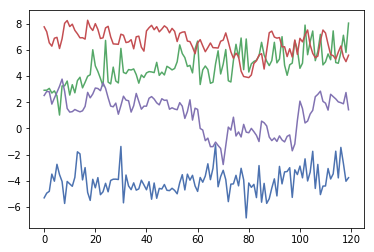

In [45]:
plt.plot(vx0est)
plt.plot(vy0est)

plt.plot(auxframedat['vx'].values)
plt.plot(auxframedat['vy'].values)



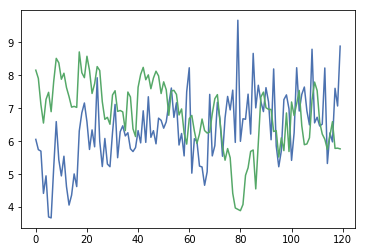

In [46]:
vmag = np.sqrt(vx0est**2 + vy0est**2)
plt.plot(vmag)

vmagaux = np.sqrt(auxframedat['vx'].values**2 + auxframedat['vy'].values**2)
plt.plot(vmagaux)

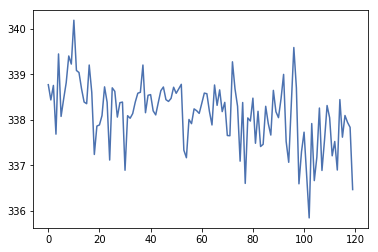

In [33]:
plt.plot(c0est)


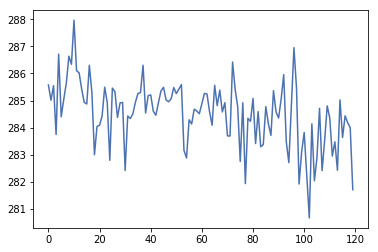

In [38]:
plt.plot(T0est)

